## Chapter 9: Principles of Feature Engineering and Selection

# 9.7 Feature selection via regularization

With the first approach to feature selection discussed in the previous Section - *boosting* - we took a 'bottom-up' approach to feature selection: that is we began by tuning the bias and then added new features to our model one-at-a-time.  In this Section we introduce a complementary approach - called *regularization*.  Instead of building up a model 'starting at the bottom', with regularization we take a 'top-down' view and start off with a complete model that includes every one of our input features, and then we gradually remove input features of inferior importance.  We do this by adding a second function to our cost - called a *regularizer*  - that penalizes weights associated with less important input features.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import basics_library as baslib

# demos for this notebook
plotter = superlearn.sparse_feature_selection_static
optimizers = optlib.optimizers
datapath = '../../mlrefined_datasets/superlearn_datasets/'
cost_lib = superlearn.cost_functions
classification_plotter = superlearn.classification_static_plotter.Visualizer();

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 9.7.1 Regularization using simple vector norms

The simple linear combination of two functions $f_1$ and $f_2$ 

\begin{equation}
f\left(\mathbf{w}\right) = f_1(\mathbf{w})+\lambda\,\,f_2(\mathbf{w})
\end{equation}

is often referred to as *regularization* in the parlance of machine learning.  More specifically the function $f_2$ is called a *regularizer* in the jargon of machine learning, since by adding it to function $f_1$ we adjust its shape, and $\lambda \geq 0$ is referred to as a penalty or regularization parameter (we have already seen one instance of regularization in discussing how to adjust Newton's method to deal with non-convex functions in Chapter 5).  

Here when $\lambda = 0$ the above combination reduces to $f_1$, and as we increase $\lambda$ the two functions $f_1$ and $f_2$ 'compete for dominance' in a linear combination of the two functions which takes on properties of both functions (see the book Appendix for several visual examples).  As we set $\lambda$ to larger and larger values the function $f_2$ dominates the combination, and eventually completely drowns out function $f_1$.  In this instance what we end up with is a highly positively scaled version of the regularizer $f_2$.

Suppose we added a generic function $h\left(\cdot\right)$ to one of our supervised learning functions e.g., the Least Squares $g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}\left(\mathbf{x}_p^{\,},\mathbf{w}\right)  - \overset{\,}{y}_{p}^{\,}\right)^{2}$, giving a regularized linear combination of our cost function

\begin{equation}
f\left(\mathbf{w}\right) = g\left(\mathbf{w}\right) + \lambda \, h\left(\mathbf{w}\right).
\end{equation}

By adding the regularizer $h\left(\mathbf{w}\right)$ to $g$ we alter its very nature, and in particular change the location of its minima (see example 3 in the book Appendix).  The larger we set the regularization parameter $\lambda$ the more the combination $f$ drifts towards a positively scaled version of the regularizer $h$ with minima that mirror closely those of $h$.

By carefully engineering $h$ and the value of $\lambda$, we can construct a *regularized* form of the original cost function that retains the essence of $g$ - in that it measures a regression error of a model against a set of input/output data points - but whose altered minima better reflect *only the most input features of a dataset*.  One can do this just as easily with a *convex combination* of a cost function and another function $h$ - but the regularization paradigm is more popular in machine learning.

A common choice for $h$ that achieve these desired aims is a  *vector norm* - in particular the so-called $\ell_1$ norm.  Remember that a vector norm is a simple function for measuring the *magnitude* or *length* of a vector (see Appendix for further details).  Below we discuss several basic choices of vector norms, the latter two of which are very commonly used in machine learning applications.

#### <span style="color:#a50e3e;">Example 4: </span>  Regularization using the $\ell_0$ norm

The $\ell_0$ vector norm, written as $\left \Vert \mathbf{w} \right \Vert_0$, measures 'magnitude' as

\begin{equation}
\left \Vert \mathbf{w} \right \Vert_0 = \text{number of non-zero entries of  } \mathbf{w}.
\end{equation}

If we regularize a cost $g$ using it 

\begin{equation}
f\left(\mathbf{w}\right) = g\left(\mathbf{w}\right) + \lambda \,  \left \Vert \mathbf{w} \right \Vert_0
\end{equation}

notice what we are doing: we are *penalizing* the regularized cost *for every non-zero entry of $\mathbf{w}$* since every non-zero entry *adds $+1$* to the magnitude $\left \Vert \mathbf{w} \right \Vert_0$.  Conversely then, in  *minimizing this sum*, the two functions $g$ and $\left \Vert \mathbf{w} \right \Vert_0$ 'compete for dominance' with $g$ wanting $\mathbf{w}$ to be resolved so that we attain a strong regression fit, while the regularizer $\left \Vert \mathbf{w} \right \Vert_0$ *aims to determine a 'small' $\mathbf{w}$ that has as few non-zero elements as possible* (or - in other words - a weight vector $\mathbf{w}$ that is very *sparse*). 

#### <span style="color:#a50e3e;">Example 5: </span>  Regularization using the $\ell_1$ norm

The $\ell_1$ vector norm, written as $\left \Vert \mathbf{w} \right \Vert_1$, measures 'magnitude' as

\begin{equation}
\left \Vert \mathbf{w} \right \Vert_1 = \sum_{n=0}^N \left \vert w_n \right \vert.
\end{equation}

If we regularize a regression cost $g$ (or - as we will see - any machine learning cost) using it 

\begin{equation}
f\left(\mathbf{w}\right) = g\left(\mathbf{w}\right) + \lambda \,  \left \Vert \mathbf{w} \right \Vert_1
\end{equation}

notice what we are doing: we are *penalizing* the regularized cost *based on the sum of the absolute value of the entries of $\mathbf{w}$*.  

Conversely then, in  *minimizing this sum*, the two functions $g$ and $\left \Vert \mathbf{w} \right \Vert_1$ 'compete for dominance' with $g$ wanting $\mathbf{w}$ to be resolved so that we attain a strong regression fit, while the regularizer $\left \Vert \mathbf{w} \right \Vert_1$ aims to determine a $\mathbf{w}$ that is small both in terms of the absolute value of each of its components but also - because the $\ell_1$ norm is so closely related to the $\ell_0$ norm (see Appendix) - one that has few non-zero entries and is quite *sparse*. 

#### <span style="color:#a50e3e;">Example 6: </span>  Regularization using the $\ell_2$ norm

The $\ell_1$ vector norm, written as $\left \Vert \mathbf{w} \right \Vert_2$, measures 'magnitude' as

\begin{equation}
\left \Vert \mathbf{w} \right \Vert_2 = \sqrt{\left(\sum_{n=0}^N w_n^2 \right )}.
\end{equation}

If we regularize a regression cost $g$ (or - as we will see - any machine learning cost) using it

\begin{equation}
f\left(\mathbf{w}\right) = g\left(\mathbf{w}\right) + \lambda \,  \left \Vert \mathbf{w} \right \Vert_2
\end{equation}

notice what we are doing: we are *penalizing* the regularized cost *based on the sum of squares of the entries of $\mathbf{w}$*.  

Conversely then, in  *minimizing this sum*, the two functions $g$ and $\left \Vert \mathbf{w} \right \Vert_2$ 'compete for dominance' with $g$ wanting $\mathbf{w}$ to be resolved so that we attain a strong regression fit, while the regularizer $\left \Vert \mathbf{w} \right \Vert_2$ aims to determine a $\mathbf{w}$ that is small in the sense that *all of its entries* have a small *squared* value. 

## 9.7.2  Feature selection via $\ell_1$ regularization

From the perspective of machine learning, by inducing the discovery of *sparse minima* the $\ell_0$ and $\ell_1$ reguarlizers help uncover the identity of a dataset's *most important features*: these are precisely the features associated with the non-zero feature-touching weights.  This makes both norms - at least in principle - quite appropriate for our current application.  On the other hand, the drive for general 'smallness' induced by minimizing a cost with the $\ell_2$ regularizer means - provided $\lambda$ is set correctly - that typically *every* weight is included in the minima recovered.  This makes the $\ell_2$ intuitively less appealing for the application of feature selection (although it is used throughout machine learning as a regularizer for applications other than feature selection, as we will see).

Of the two sparsity-inducing norms described here the $\ell_0$ norm - while promoting sparsity to the greatest degree - is also the most challenging to employ since it is *discontinuous* making the minimization of an $\ell_0$ regularized cost function quite difficult.  While the $\ell_1$ norm induces sparsity to less of a degree, it is *convex and continuous* and so we have no practical problem minimizing a cost function where it is used as regularizer.  Because of this practical advantage the $\ell_1$ norm is by far the more commonly used regularizer for feature selection.

Finally, remember that when performing feature selection we are only interested in determining the importance of *feature-touching* weights $w_1,\,w_2,\,...,w_N$ we only need regularize them (and not the bias weight $w_0$), and so our regularization will more specifically take the form

\begin{equation}
f\left(\mathbf{w}\right) = g\left(\mathbf{w}\right) + \lambda \,  \sum_{n=1}^N \left\vert w_n \right\vert.
\end{equation}

where $g$ is any supervised learning cost function.  

Using our individual notation for the bias and feature-touching weights (used in e.g., Section 6.3.4)

\begin{equation}
\text{(bias):}\,\, b = w_0 \,\,\,\,\,\,\,\, \text{(feature-touching weights):} \,\,\,\,\,\, \boldsymbol{\omega} = 
\begin{bmatrix}
w_1 \\
w_2 \\ 
\vdots \\
w_N
\end{bmatrix}.
\end{equation}

we can write this general $\ell_1$ regularized cost function equivalently as

\begin{equation}
f\left(b,\boldsymbol{\omega}\right) = g\left(b,\boldsymbol{\omega}\right)  + \lambda \,  \left\Vert  \boldsymbol{\omega} \right\Vert_1.
\end{equation}

We have seen feature-touching regularized supervised learning cost functions before, e.g., throughout Chapters 6 and 7.

## 9.7.3  What value should $\lambda$ be set too?

Because feature selection is done for the purposes of *human interpretation* the value of $\lambda$ can be based on several factors.  A benchmark value for $\lambda$ can be hand chosen based on the desire to explore a dataset, finding a value that provides sufficient sparsity while retaining a low cost value.  Finally, $\lambda$ can be chosen entirely based on the sample statistics of the dataset via a procedure known as *cross-validation* (which we discuss in Section 12.6).

Regardless of how we select $\lambda$, note that because we are trying to determine the *importance* of each input feature here that before we begin the process of boosting we *always need to standard normalize the input to our dataset* as detailed in Section 8.3.  By normalizing each input feature distribution we can fairly compare each input feature's contribution and determine the importance of each.

#### <span style="color:#a50e3e;">Example 1: </span>  Exploring features for predicting housing prices via $\ell_1$ regularized regression

In this example we use the Boston Housing dataset first introduced in Example 1 of the previous Section.  This dataset consists of $P=506$ datapoints with $N=13$ input features relating various statistics about homes in the Boston area to their median values (in U.S. dollars).  We use $\ell_1$ regularization with $50$ evenly spaced values for $\lambda$ in the range $\left[0, 130 \right]$.  Shown in the animated figure below is a histogram of the optimal *feature-touching* weights recovered by minimizing an $\ell_1$ regularized Least Squares cost function with these various $\lambda$ values.  In each case we run $1000$ steps of gradient descent were taken with $\alpha = 10^{-1}$ for all runs. 

Moving the slider from its starting position on the left (where $\lambda = 0$) rightwards increases the value of $\lambda$ and the associated optimal set of weights are shown.  Pushing the slider all the way to the right shows the optimal weights resulting in using the maximum value for $\lambda$ used in these experiments.  As you move the slider from left to right you can see how the resulting optimal featre-touching weights begin to *sparsify*, with many of them diminishing to near zero values.  By the time $\lambda \approx 75$ three major weights remain, corresponding to feature $6$, feature $13$, and feature $11$.  The first two features ($6$ and $13$) were also determined to be important via boosting - and can be easily interpreted. 

In comparison to the result found via boosting, the third feature $11$ found to be important here was *not* found to be as important via boosting.  Conversely as $\lambda$ is increased to even small values notice how many of the large (in magnitude) feature-touching weights seen when $\lambda = 0$ quickly disappear - in particular feature-touching weights $8$ and $11$ rapidly vanish (which were deemed more important when applying boosting).


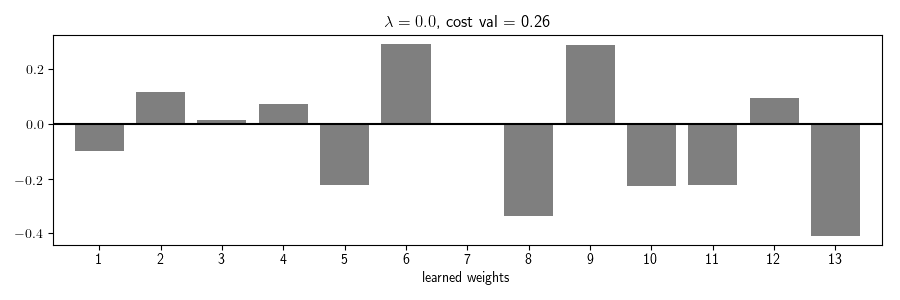
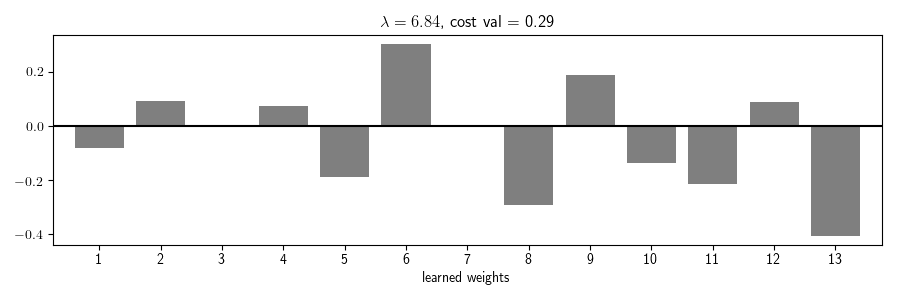
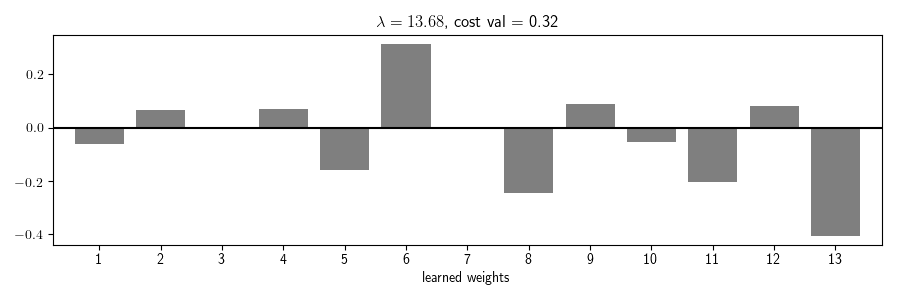
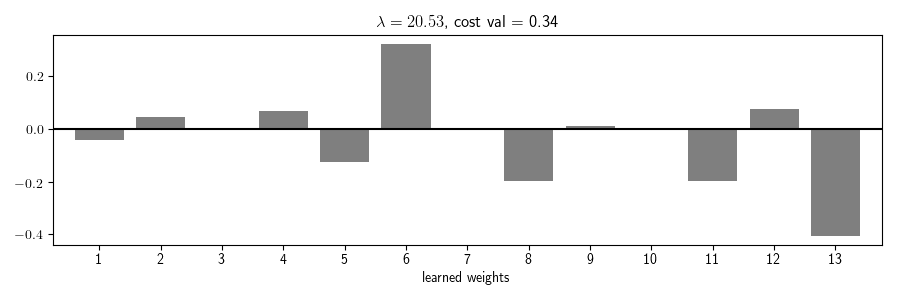
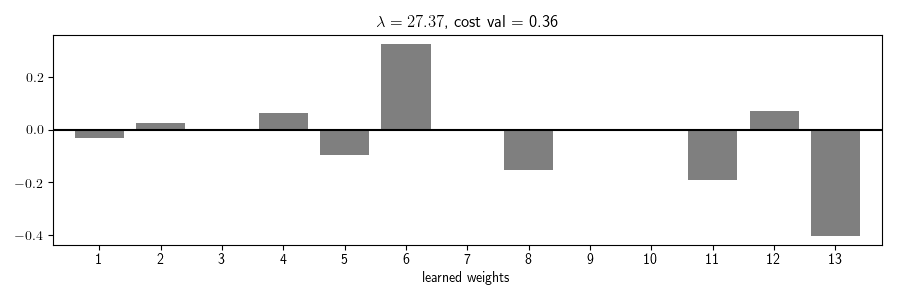
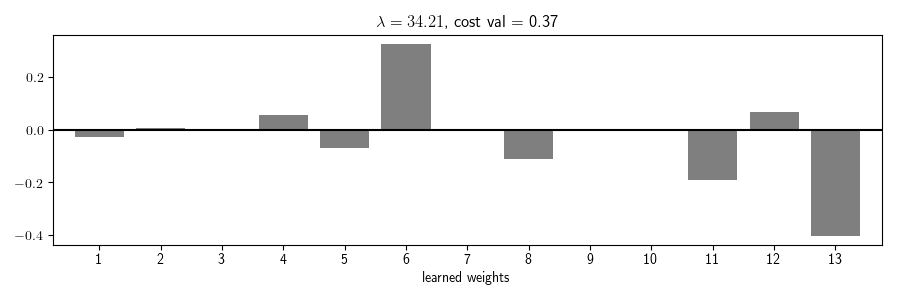
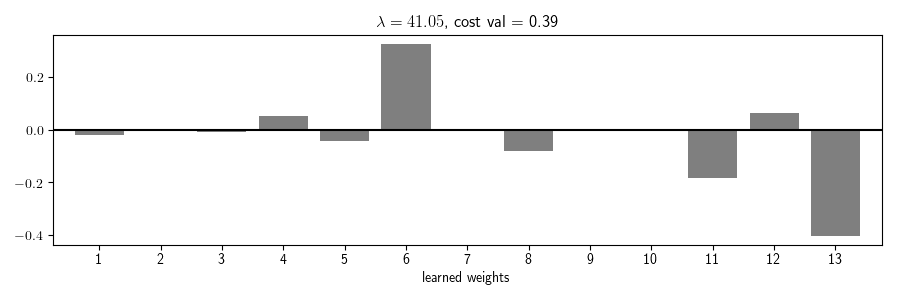
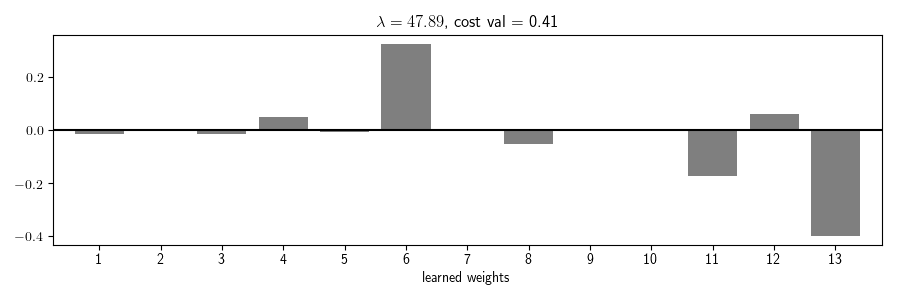
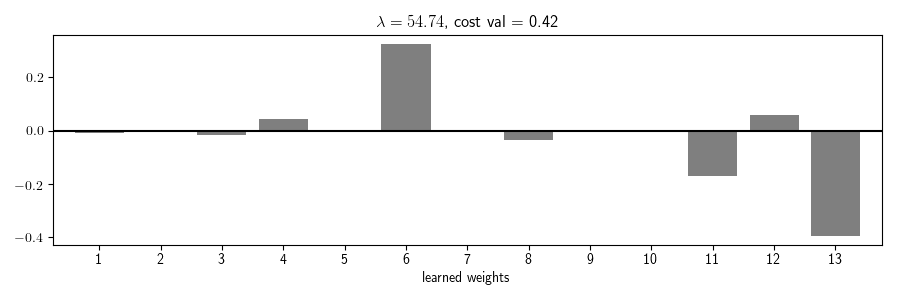
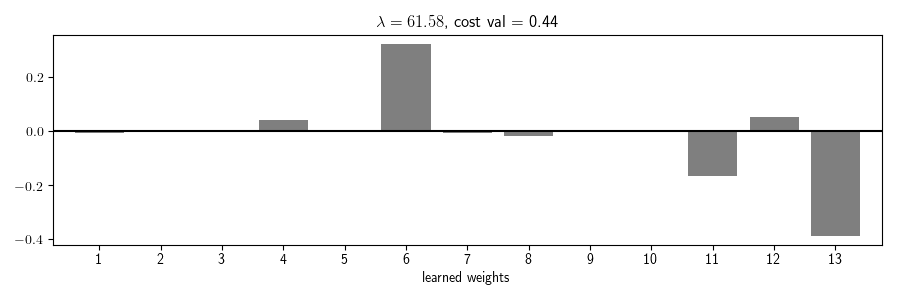
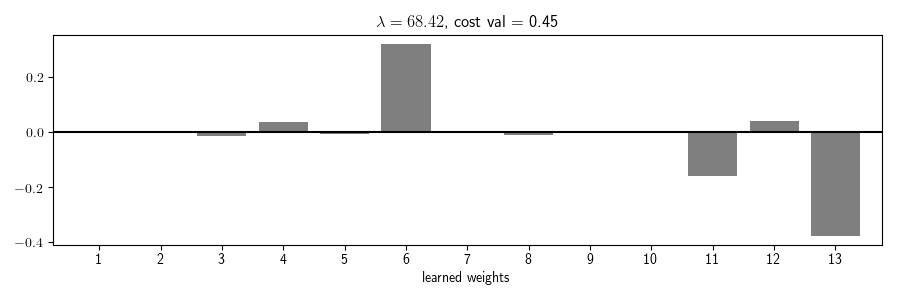
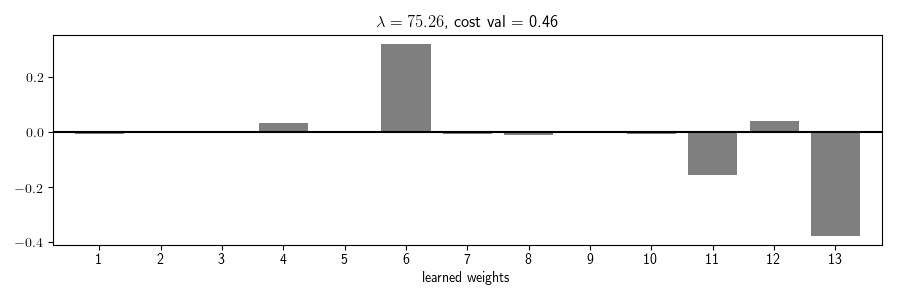
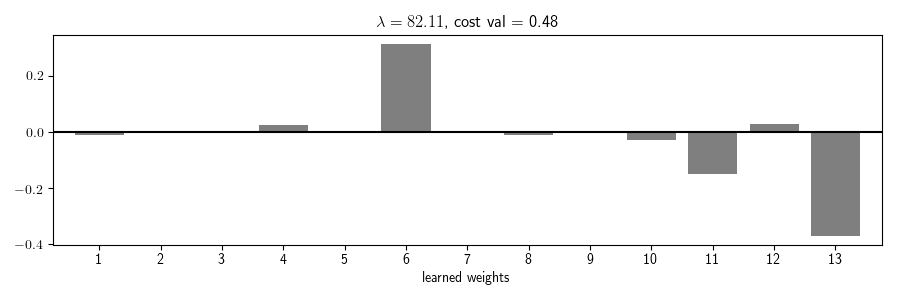
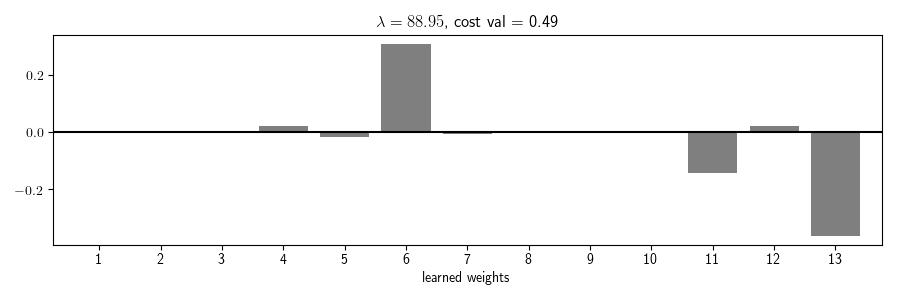
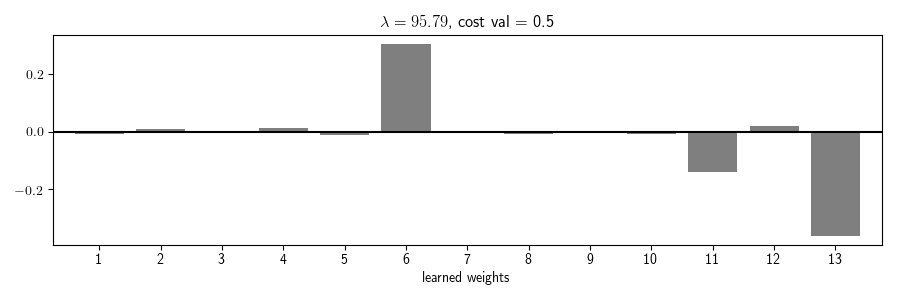
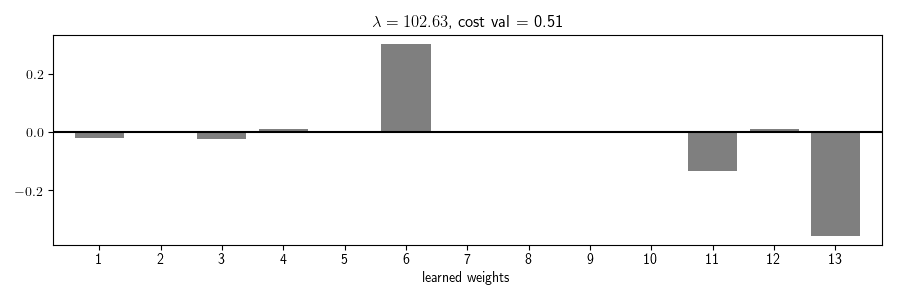
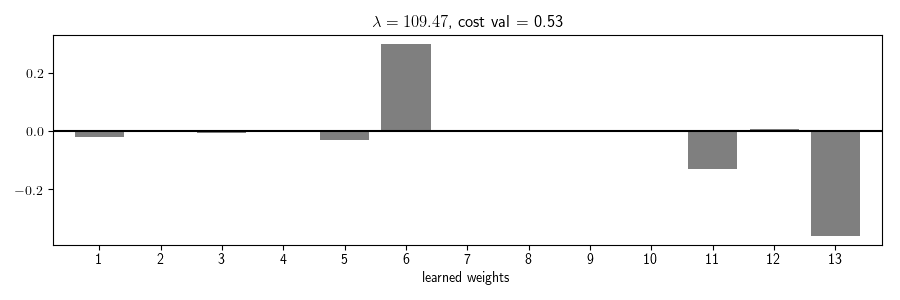
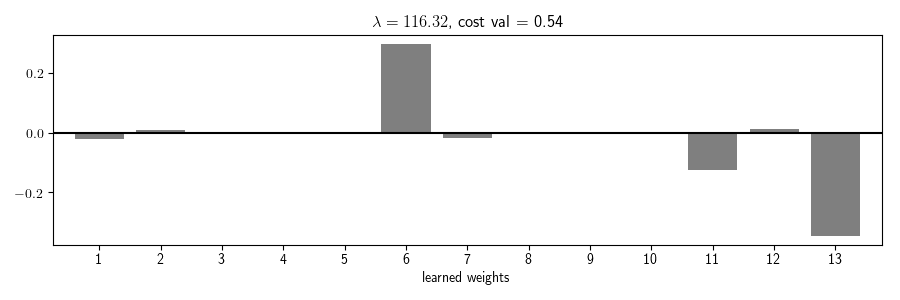
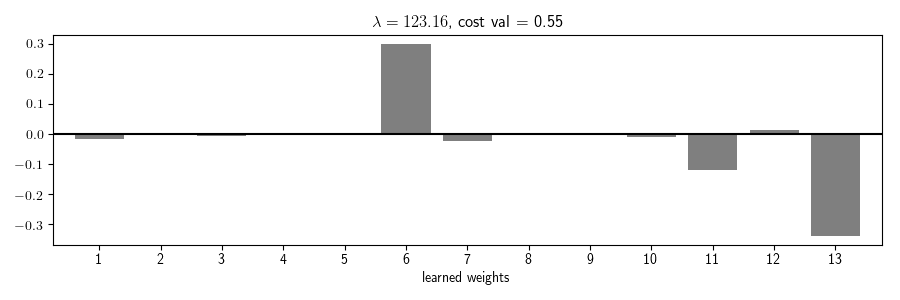
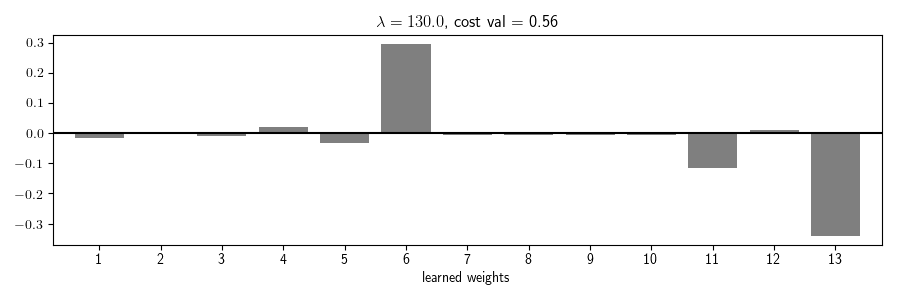

In [100]:
## This code cell will not be shown in the HTML version of this notebook
# load in data
csvname =  datapath + 'boston_housing.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# import booster
mylib = superlearn.reg_lib.superlearn_setup.Setup(x,y)

# choose normalizer
mylib.choose_normalizer(name = 'standard')

# choose cost
mylib.choose_cost(cost_name = 'least_squares',reg_name = 'L1')

# choose optimizer
mylib.choose_optimizer('gradient_descent',max_its=1000,alpha_choice=10**(-1))

# run regularization
lams = np.linspace(0,mylib.x.shape[0]*10,20)
mylib.tryout_lams(lams)

# plot round history
mylib.animate_lams()

Below we show the an analogous run - using the same range of values for $\lambda$ - employing the $\ell_2$ norm.  This does not sparsify the resulting weights like the $\ell_1$ norm does, and so results in optimal weights that are less human interpretable.


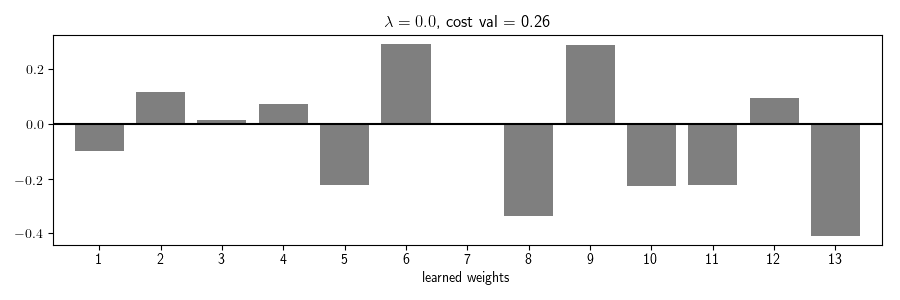
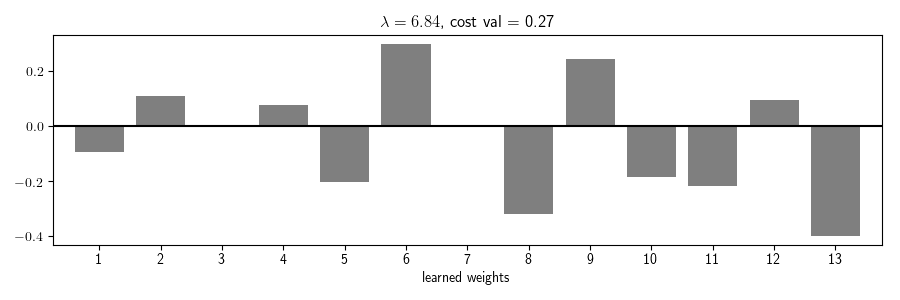
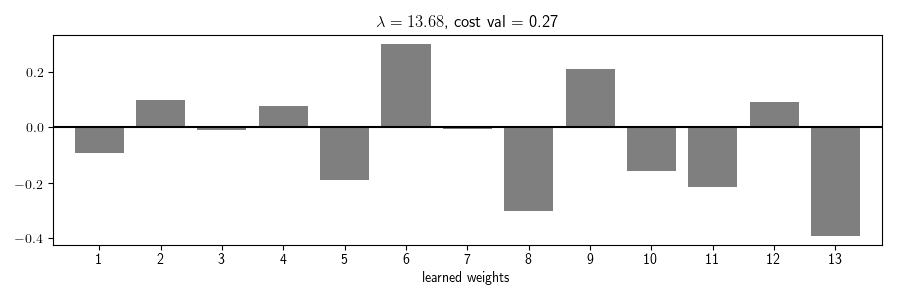
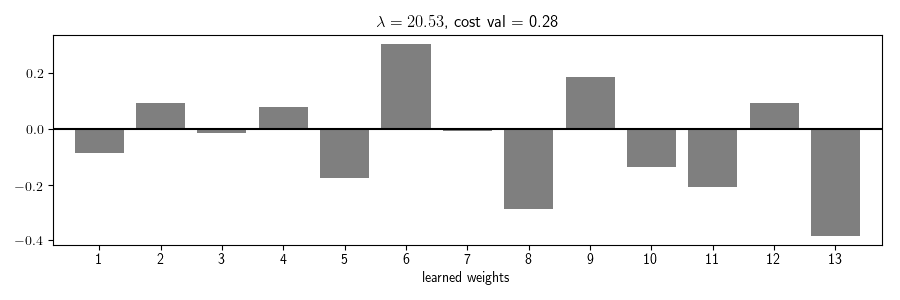
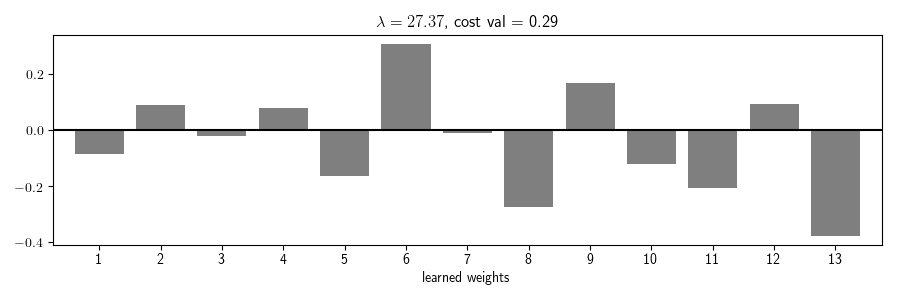
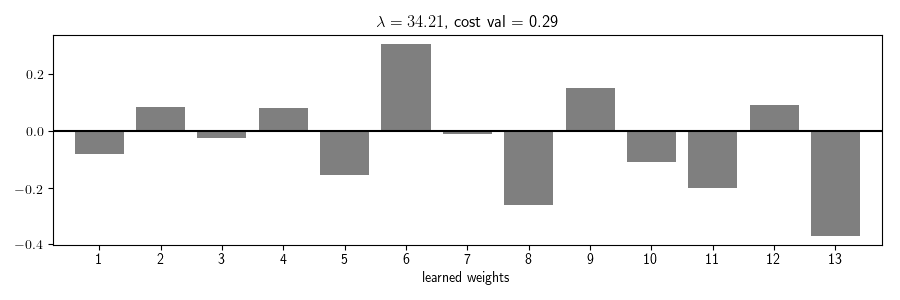
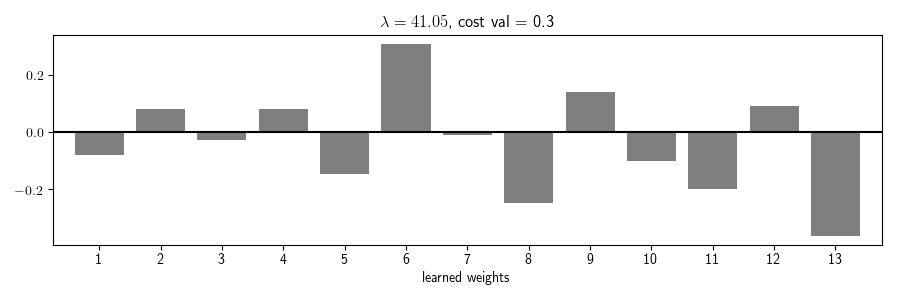
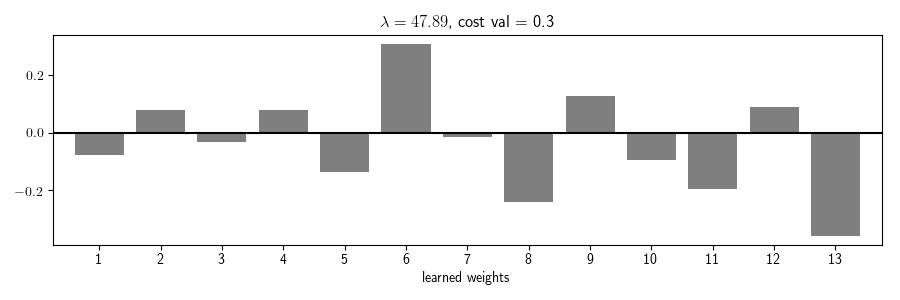
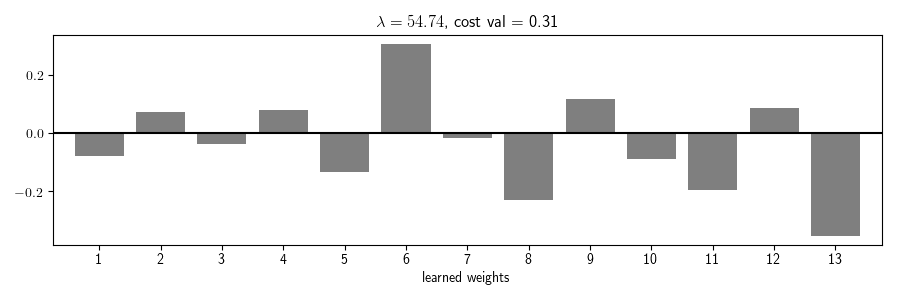
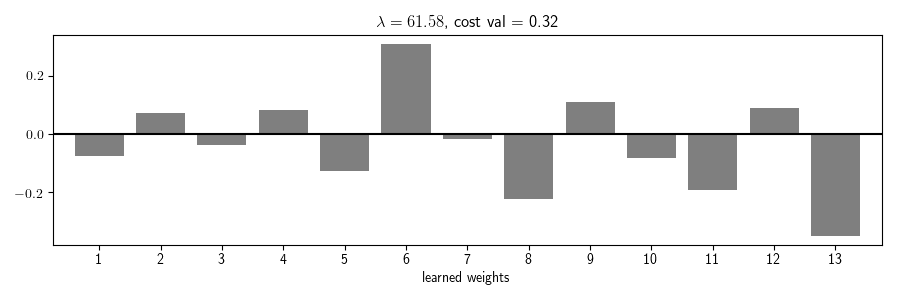
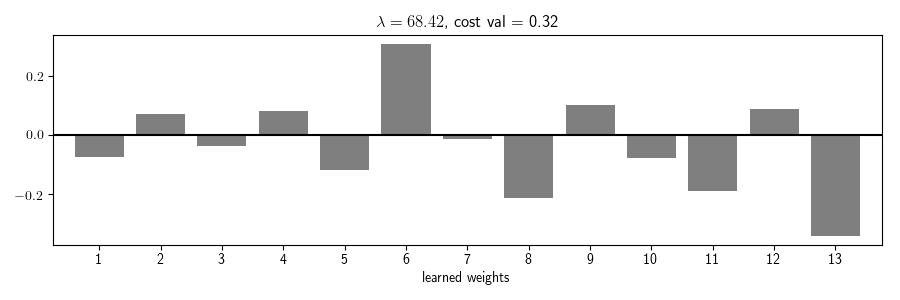
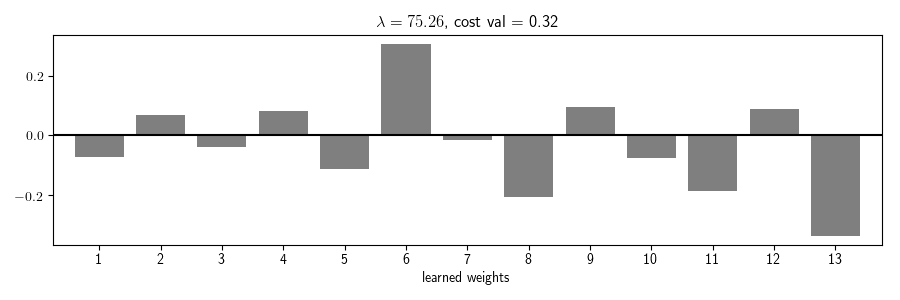
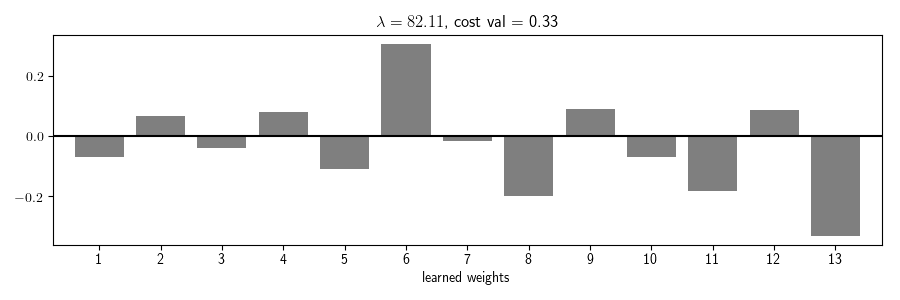
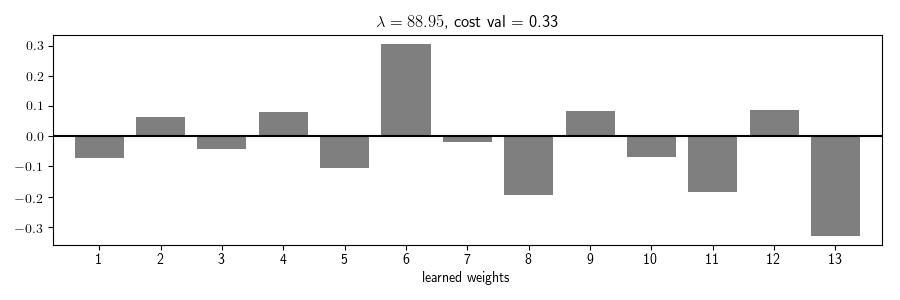
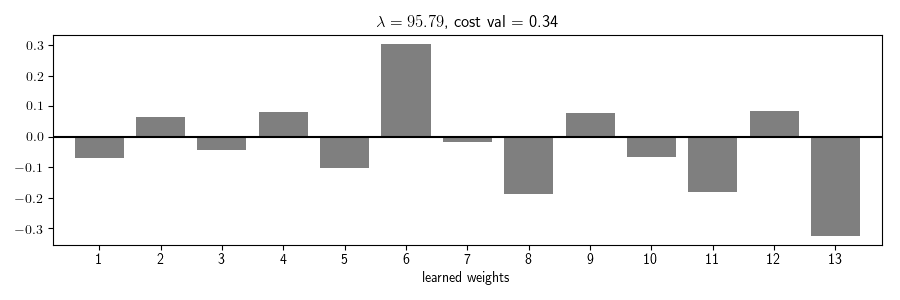
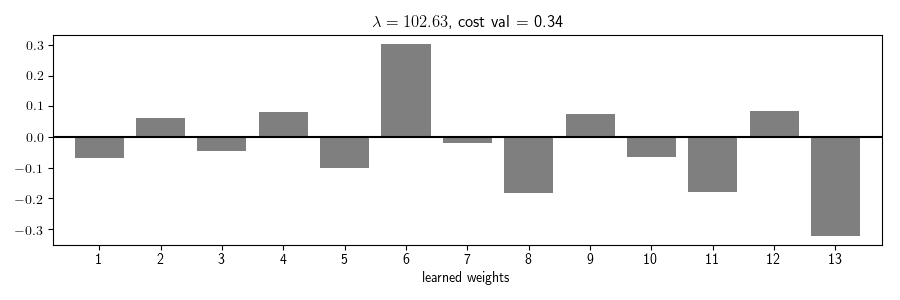
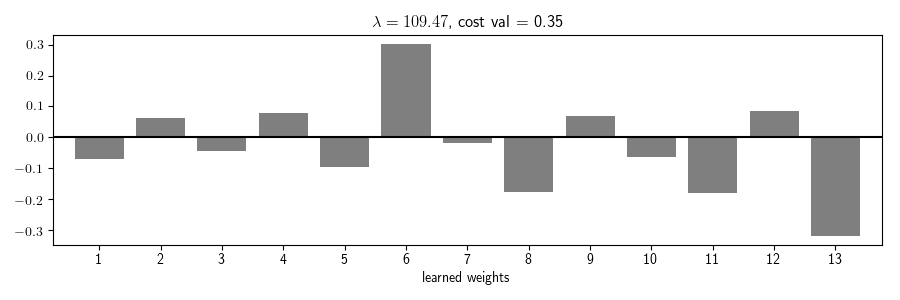
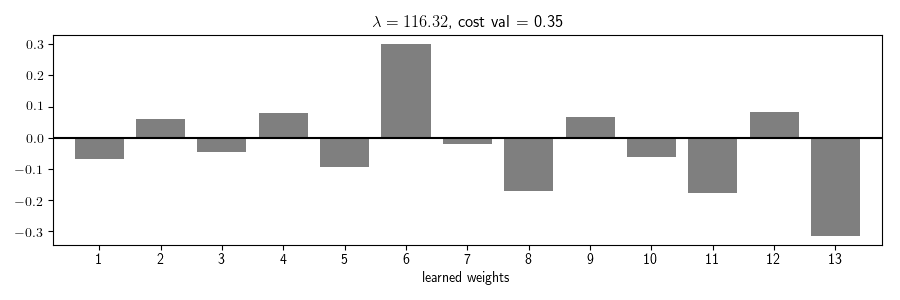
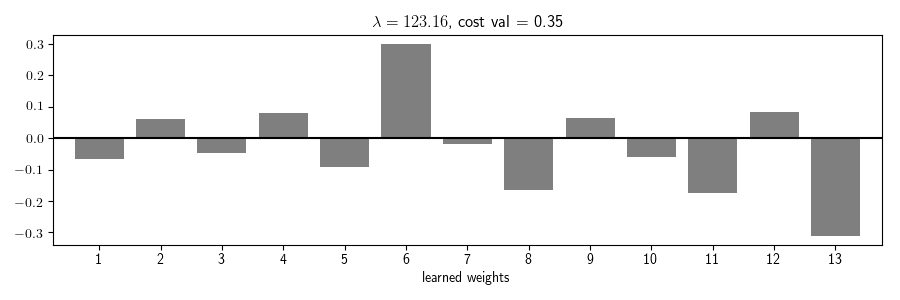
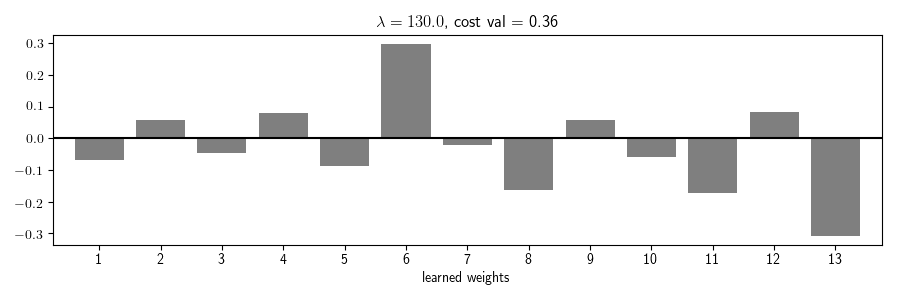

In [101]:
## This code cell will not be shown in the HTML version of this notebook
# load in data
csvname =  datapath + 'boston_housing.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# import booster
mylib = superlearn.reg_lib.superlearn_setup.Setup(x,y)

# choose normalizer
mylib.choose_normalizer(name = 'standard')

# choose cost
mylib.choose_cost(cost_name = 'least_squares',reg_name = 'L2')

# choose optimizer
mylib.choose_optimizer('gradient_descent',max_its=1000,alpha_choice=10**(-1))

# run boosting
lams = np.linspace(0,mylib.x.shape[0]*10,20)
mylib.tryout_lams(lams)

# plot round history
mylib.animate_lams()

#### <span style="color:#a50e3e;">Example 2: </span>  Exploring features for classifying credit risk of loan applicants via $\ell_1$ regularization

In this example we use the Credit Risk dataset first introduced in Example 2 of the previous Section.  This dataset consists of $P=1000$ datapoints with $N=20$ input features relating various statistics about loan applicants to their assessed credit risk.  We use $\ell_1$ regularization with $50$ evenly spaced values for $\lambda$ in the range $\left[0, 130 \right]$.  Shown in the animated figure below is a histogram of the optimal *feature-touching* weights recovered by minimizing an $\ell_1$ regularized Least Squares cost function with these various $\lambda$ values.  In each case we run $1000$ steps of gradient descent were taken with $\alpha = 10^{-1}$ for all runs. 

Moving the slider from its starting position on the left (where $\lambda = 0$) rightwards increases the value of $\lambda$ and the associated optimal set of weights are shown.  Pushing the slider all the way to the right shows the optimal weights resulting in using the maximum value for $\lambda$ used in these experiments.  As you move the slider from left to right you can see how the resulting optimal featre-touching weights begin to *sparsify*, with many of them diminishing to near zero values.  By the time $\lambda \approx 40$ five major weights remain, corresponding to feature $1 - 3$ and $6 - 7$.  The first there features were also determined to be important via boosting - and can be easily interpreted. 


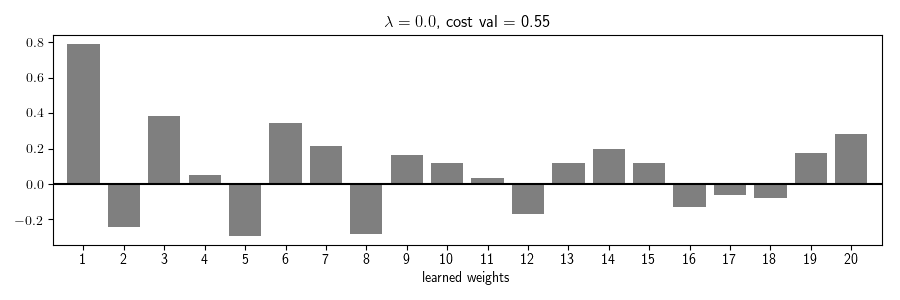
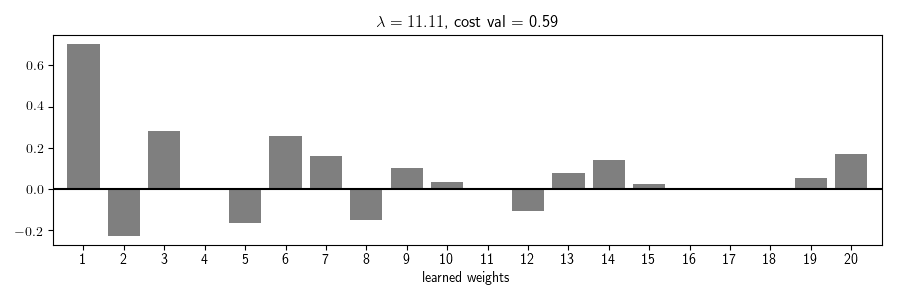
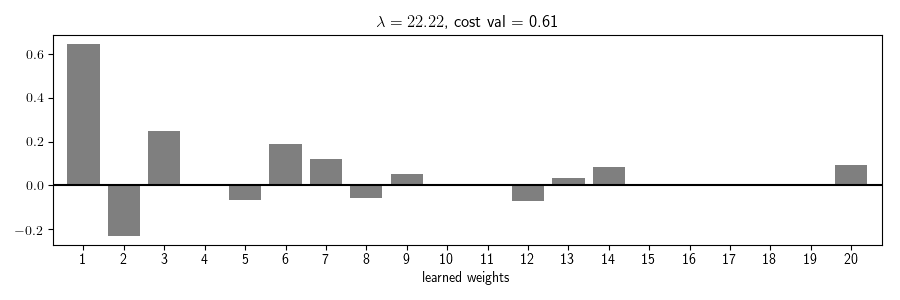
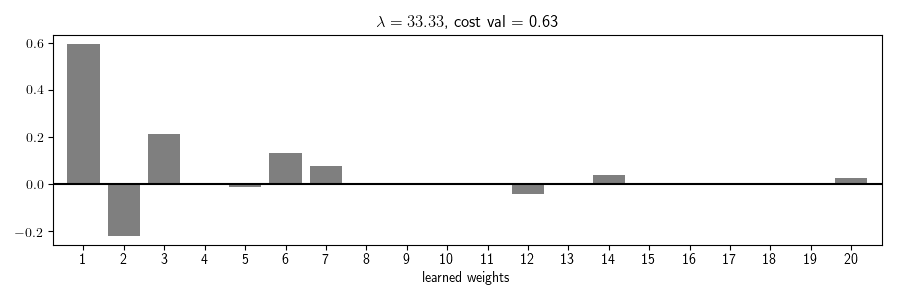
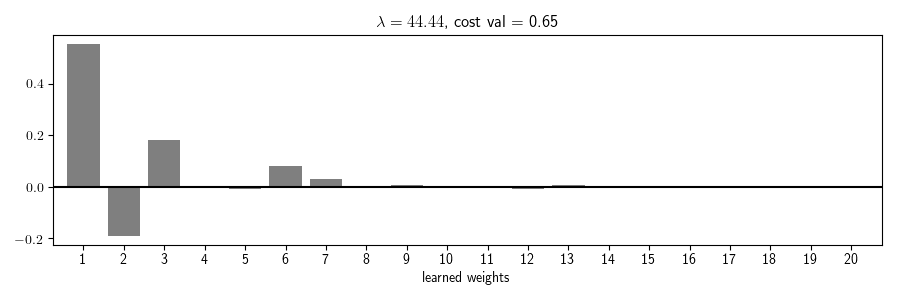
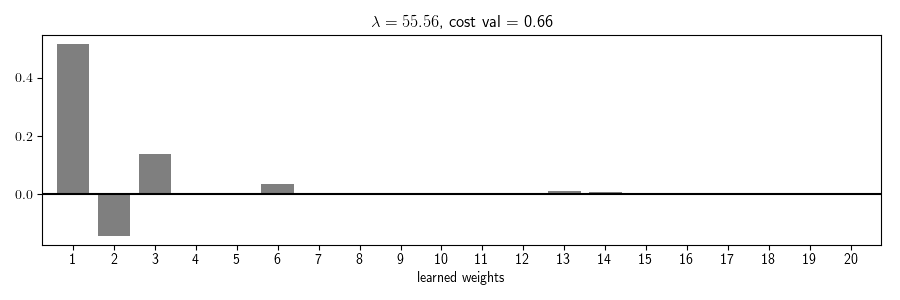
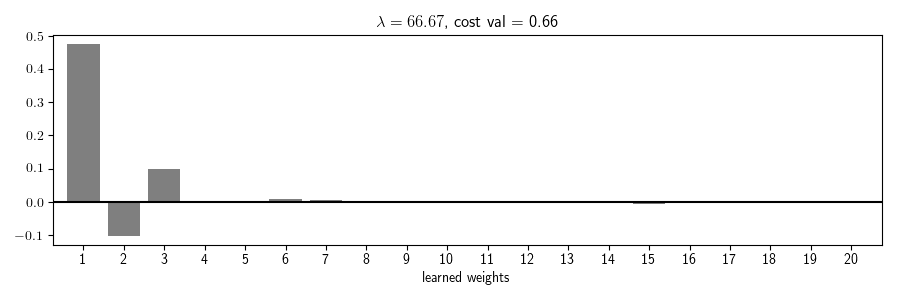
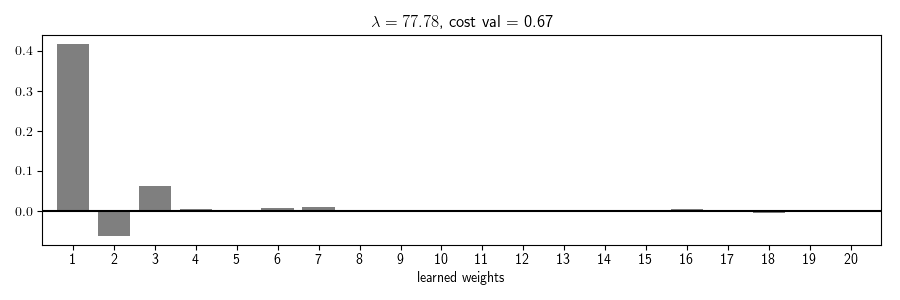
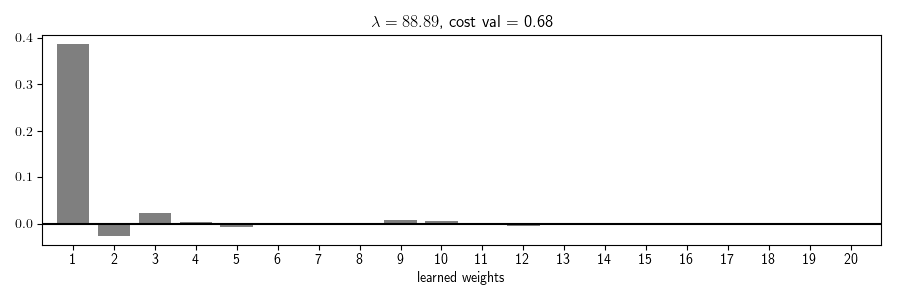
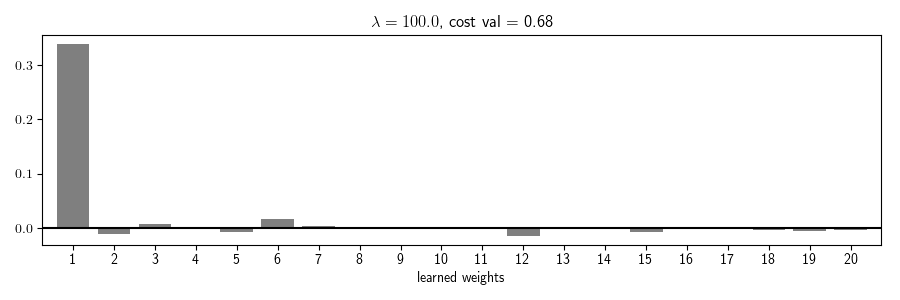

In [7]:
# load in dataset
csvname = datapath + 'credit_dataset.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# import booster
mylib = superlearn.reg_lib.superlearn_setup.Setup(x,y)

# choose normalizer
mylib.choose_normalizer(name = 'standard')

# choose cost
mylib.choose_cost(cost_name = 'softmax',reg_name = 'L1')

# choose optimizer
mylib.choose_optimizer('gradient_descent',max_its=1000,alpha_choice=10**(-1))

# run regularization
lams = np.linspace(0,demo.y.size*10**(-1),10)
mylib.tryout_lams(lams)

# plot round history
mylib.animate_lams()

## 9.7.4  Comparing regularization and boosting

While boosting is an efficient greedy scheme, the *regularization* idea detailed above can be computationally intensive to perform since for each value of $\lambda$ tried a full run of local optimization must be completed.  On the other hand, while boosting is a 'bottom-up' approach that identifies individual features one-at-a-time, regularization takes a more 'top-down' approach and identifies important features *all at once*.  In principle this allows regularization to uncover groups of important features that may be correlated in such an interconnected way with the output that they will be missed by boosting.